<a href="https://colab.research.google.com/github/ElenaNtm/power-thefts-investigation/blob/main/hedno_model(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [ ]:
import pandas as pd 
import numpy as np
import math
import operator 
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import balanced_accuracy_score
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.linear_model import RidgeClassifier

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting 
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#scoring 
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

#Data

In [ ]:
path = "/content/drive/MyDrive/HEDNO/Edo_ola/train_data"
train_data = pd.read_csv(path)
train_data.head()

,ACCT_NBR,SUCCESSOR,VOLTAGE,PARNO,XRHSH,CONTRACT_CAPACITY,ACCT_CONTROL,ACCT_WGS84_X,ACCT_WGS84_Y,TOTAL_SUPPLIER,LAST_SUPPLIER,START_DATE,END_DATE,TOTAL_MS_METER_NBR,target
0,000A31FE38C6F648845941B642E287FE0200000000004A...,1,0.0,0,2,12.0,0,53.422552,19.592758,1.0,23.0,434.0,925.0,1.0,0
1,000A31FE38C6F648845941B642E287FE0200000000008D...,1,0.0,0,2,12.0,0,53.407109,19.569744,1.0,23.0,307.0,111.0,1.0,0
2,000A31FE38C6F648845941B642E287FE0200000000008D...,3,0.0,2,2,25.0,0,53.407109,19.569744,1.0,23.0,717.0,628.0,1.0,0
3,000A31FE38C6F648845941B642E287FE0200000000008D...,4,0.0,2,2,25.0,0,53.407109,19.569744,1.0,23.0,742.0,738.0,1.0,0
4,000A31FE38C6F648845941B642E287FE0200000000008D...,5,0.0,2,2,25.0,0,53.407109,19.569744,1.0,23.0,844.0,999.0,1.0,0


In [ ]:
train_data.columns

Index(['ACCT_NBR', 'SUCCESSOR', 'VOLTAGE', 'PARNO', 'XRHSH',
       'CONTRACT_CAPACITY', 'ACCT_CONTROL', 'ACCT_WGS84_X', 'ACCT_WGS84_Y',
       'TOTAL_SUPPLIER', 'LAST_SUPPLIER', 'START_DATE', 'END_DATE',
       'TOTAL_MS_METER_NBR', 'target'],
      dtype='object')

In [ ]:
path = "/content/drive/MyDrive/HEDNO/Edo_ola/test_data"
test_data = pd.read_csv(path)
test_data.head()

,ACCT_NBR,SUCCESSOR,VOLTAGE,PARNO,XRHSH,CONTRACT_CAPACITY,ACCT_CONTROL,ACCT_WGS84_X,ACCT_WGS84_Y,TOTAL_SUPPLIER,LAST_SUPPLIER,START_DATE,END_DATE,TOTAL_MS_METER_NBR
0,000A31FE38C6F648845941B642E287FE0200000000006D...,1,0.0,0,1,12,0,53.451030,19.600792,1.0,23.0,459.0,960.0,1.0
1,000A31FE38C6F648845941B642E287FE0200000000006E...,1,0.0,0,1,12,0,53.423690,19.615367,1.0,23.0,307.0,222.0,1.0
2,000A31FE38C6F648845941B642E287FE020000000001BF...,2,0.0,2,1,25,0,53.466064,19.606420,1.0,23.0,921.0,999.0,1.0
3,000A31FE38C6F648845941B642E287FE02000000000357...,1,0.0,0,1,12,0,53.466930,19.594033,1.0,23.0,332.0,777.0,1.0
4,000A31FE38C6F648845941B642E287FE02000000000536...,1,0.0,0,1,12,0,53.465291,19.608224,1.0,23.0,307.0,665.0,1.0


In [ ]:
test_data.columns

Index(['ACCT_NBR', 'SUCCESSOR', 'VOLTAGE', 'PARNO', 'XRHSH',
       'CONTRACT_CAPACITY', 'ACCT_CONTROL', 'ACCT_WGS84_X', 'ACCT_WGS84_Y',
       'TOTAL_SUPPLIER', 'LAST_SUPPLIER', 'START_DATE', 'END_DATE',
       'TOTAL_MS_METER_NBR'],
      dtype='object')

In [ ]:
train_data.drop(['ACCT_WGS84_X', 'ACCT_WGS84_Y'], axis=1 , inplace=True)

In [ ]:
test_data.drop(['ACCT_WGS84_X', 'ACCT_WGS84_Y'], axis=1 , inplace=True)

#Index

In [ ]:
train_data = train_data.set_index(['ACCT_NBR', 'SUCCESSOR'])
test_data = test_data.set_index(['ACCT_NBR', 'SUCCESSOR'])

#Split Dataframe for the model

In [ ]:
#create feature and targets
features = train_data.drop(['target'],axis=1)
target = train_data['target']
#split data into 80% training and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

#Tuned Stacker

In [ ]:
#rom sklearn.linear_model import RidgeClassifierCV

#CLF = RidgeClassifierCV(cv=5, alphas=[0.8], class_weight='balanced')

In [ ]:
#from sklearn.utils.extmath import softmax
#class RidgeClassifierCVwithProba(RidgeClassifierCV):
 #   def predict_proba(self, X):
  #      d = self.decision_function(X)
   #     d_2d = np.c_[-d, d]
    #    return softmax(d_2d)
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
hgbm = HistGradientBoostingClassifier(l2_regularization=3, learning_rate=0.5, random_state=42, class_weight="balanced")

bbc = BalancedBaggingClassifier(
        estimator = hgbm,
        n_estimators = 10, 
        random_state = 42,
        n_jobs = -1,
)
brf = BalancedRandomForestClassifier(n_estimators = 200, random_state = 42, n_jobs = -1)
#CLF =  RidgeClassifier(random_state = 42, alpha = 0.8, max_iter = 200, class_weight = 'balanced')
gbc = GradientBoostingClassifier(random_state = 42)

Class_st = StackingClassifier(estimators=[("BalancedBaggingClassifier", bbc),
                                       ("BalancedRandomForestClassifier", brf)],
                           final_estimator = gbc, stack_method='predict_proba', cv = 5, n_jobs = -1) #, stack_method='predict_proba'
Class_st.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('BalancedBaggingClassifier',
                                BalancedBaggingClassifier(estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                                                                   l2_regularization=3,
                                                                                                   learning_rate=0.5,
                                                                                                   random_state=42),
                                                          n_jobs=-1,
                                                          random_state=42)),
                               ('BalancedRandomForestClassifier',
                                BalancedRandomForestClassifier(n_estimators=200,
                                                               n_jobs=-1,
                                                               random_state=42))],
                   final_estimator=GradientBoostingClassifier(random_state=42),
                   n_jobs=-1, stack_method='predict_proba')

In [ ]:
Class_st.score(X_test, y_test)

0.997112214562863

In [ ]:
# balanced accurancy
balanced_accuracy_score(y_test, Class_st.predict(X_test))

0.5006653032423277

<Axes: >

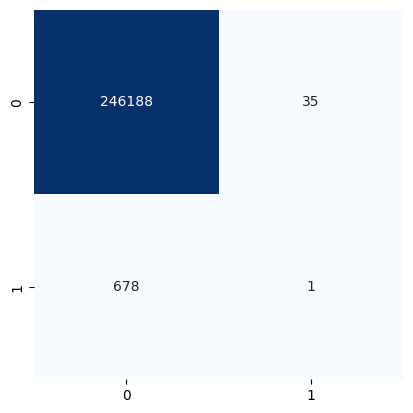

In [ ]:
conf_mat4 = confusion_matrix(y_test, Class_st.predict(X_test))
sns.heatmap(conf_mat4, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

#HistGradiantBoostingClassifier

In [ ]:
hgbm = HistGradientBoostingClassifier(l2_regularization=3, learning_rate=0.5, random_state=42, class_weight="balanced")

In [ ]:
hgbm.fit(X_train, y_train)

HistGradientBoostingClassifier(class_weight='balanced', l2_regularization=3,
                               learning_rate=0.5, random_state=42)

In [ ]:
hgbm.score(X_test, y_test)

0.6877060534139051

In [ ]:
# balanced accurancy
balanced_accuracy_score(y_test, hgbm.predict(X_test))

0.7295987424549116

In [ ]:
#from imblearn.under_sampling import RandomUnderSampler
#from collections import Counter
#rus = RandomUnderSampler(random_state=0)
#X_resampled, y_resampled = rus.fit_resample(features, target)
#print(sorted(Counter(y_resampled).items()))

<Axes: >

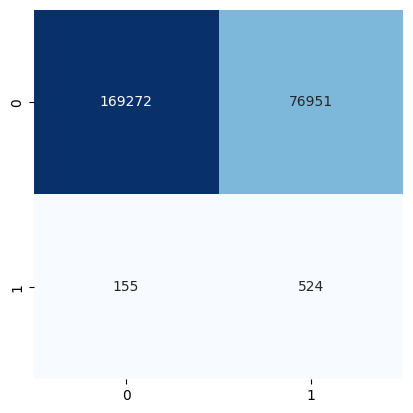

In [ ]:
conf_mat4 = confusion_matrix(y_test, hgbm.predict(X_test))
sns.heatmap(conf_mat4, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

#Balanced Random Forest

In [ ]:
brf = BalancedRandomForestClassifier(n_estimators = 200, random_state = 42, n_jobs = -1)

In [ ]:
brf.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is de

BalancedRandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
brf.score(X_test, y_test)

0.6675442078233469

In [ ]:
# balanced accurancy
balanced_accuracy_score(y_test, brf.predict(X_test))

0.7334426004392476

<Axes: >

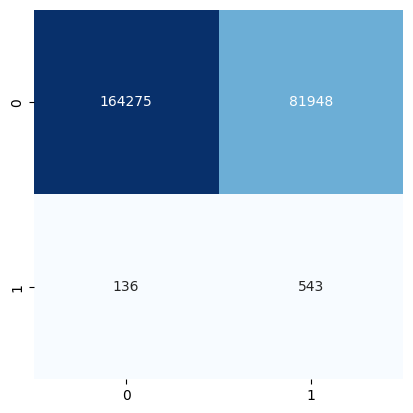

In [ ]:
conf_mat4 = confusion_matrix(y_test, brf.predict(X_test))
sns.heatmap(conf_mat4, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

#Balanced Bagging Classifier

In [ ]:
bbc = BalancedBaggingClassifier(
        estimator = hgbm,
        n_estimators = 10, 
        random_state = 42,
        n_jobs = -1,
)

In [ ]:
bbc.fit(X_train, y_train)

BalancedBaggingClassifier(estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                                   l2_regularization=3,
                                                                   learning_rate=0.5,
                                                                   random_state=42),
                          n_jobs=-1, random_state=42)

In [ ]:
bbc.score(X_test, y_test)

0.7203789357720877

In [ ]:
# balanced accurancy
balanced_accuracy_score(y_test, bbc.predict(X_test))

0.7423085023019681

In [ ]:
conf_mat4 = confusion_matrix(y_test, bbc.predict(X_test))
sns.heatmap(conf_mat4, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

#Gradient Boosting Classifier (Tune first)




In [ ]:
GradientBoostingClassifier(random_state = 42).get_params(deep=True)

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
parameters = [ { 'learning_rate':[0.1,0.3,0.5,0.6,0.8],
                  'max_depth':[3,5,10],
                  #'max_iter':[50,100,200],
                 #'l2_regularization':[2,3,4,5]
                } ]

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
gbc = GradientBoostingClassifier(random_state = 42)
Reg = HalvingGridSearchCV(gbc, parameters, random_state=42, n_jobs=-1, aggressive_elimination=True, scoring='balanced_accuracy')
Reg.fit(X_train, y_train) #θελει ενα τεταρτο να το τρεξεις εχω τις απαντησεις πανω

#New stacker


In [ ]:
hgbm = HistGradientBoostingClassifier(l2_regularization=3, learning_rate=0.5, random_state=42, class_weight="balanced")

bbc = BalancedBaggingClassifier(
        estimator = hgbm,
        n_estimators = 10, 
        random_state = 42,
        n_jobs = -1,
)
brf = BalancedRandomForestClassifier(n_estimators = 200, random_state = 42, n_jobs = -1)
#CLF =  RidgeClassifier(random_state = 42, alpha = 0.8, max_iter = 200, class_weight = 'balanced')
#gbc = GradientBoostingClassifier(random_state = 42)

Class_st1 = StackingClassifier(estimators=[("HistGradientBoostingClassifier", hgbm),
                                       ("BalancedRandomForestClassifier", brf)],
                           final_estimator = bbc, stack_method='predict_proba', cv = 5, n_jobs = -1) #, stack_method='predict_proba'
Class_st1.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('HistGradientBoostingClassifier',
                                HistGradientBoostingClassifier(class_weight='balanced',
                                                               l2_regularization=3,
                                                               learning_rate=0.5,
                                                               random_state=42)),
                               ('BalancedRandomForestClassifier',
                                BalancedRandomForestClassifier(n_estimators=200,
                                                               n_jobs=-1,
                                                               random_state=42))],
                   final_estimator=BalancedBaggingClassifier(estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                                                                      l2_regularization=3,
                                                                                                      learning_rate=0.5,
                                                                                                      random_state=42),
                                                             n_jobs=-1,
                                                             random_state=42),
                   n_jobs=-1, stack_method='predict_proba')

In [ ]:
Class_st1.score(X_test, y_test)

0.687892362151785

In [ ]:
# balanced accurancy
balanced_accuracy_score(y_test, Class_st1.predict(X_test))

0.7296921537121865

<Axes: >

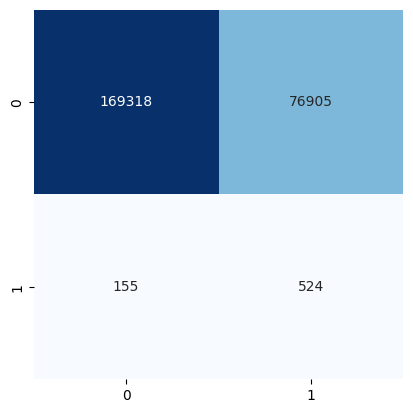

In [ ]:
conf_mat4 = confusion_matrix(y_test, Class_st1.predict(X_test))
sns.heatmap(conf_mat4, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

#Saving Model

In [ ]:
# save the model to disk
#filename = 'final_model.sav'
#joblib.dump(Class_st, filename)

In [ ]:
# load the model from disk
#filename = 'final_model.sav'
#loaded_model = joblib.load(filename)
#result = loaded_model.score(X_test, y_test)
#print(result)

#OneVsRest NOT NEEDED

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
# define the ovr strategy
ovr = OneVsRestClassifier(Class_st)
# fit model
ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=StackingClassifier(cv=5,
                                                 estimators=[('BalancedBaggingClassifier',
                                                              BalancedBaggingClassifier(estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                                                                                                 l2_regularization=3,
                                                                                                                                 learning_rate=0.5,
                                                                                                                                 random_state=42),
                                                                                        n_jobs=-1,
                                                                                        random_state=42)),
                                                             ('BalancedRandomForestClassifier',
                                                              BalancedRandomForestClassifier(n_estimators=200,
                                                                                             n_jobs=-1,
                                                                                             random_state=42))],
                                                 final_estimator=GradientBoostingClassifier(random_state=42),
                                                 n_jobs=-1,
                                                 stack_method='predict_proba'))

In [ ]:
ovr.score(X_test,y_test)

0.9917541798353872

In [ ]:
# balanced accurancy
balanced_accuracy_score(y_test, ovr.predict(X_test))

0.5756087548355984

In [ ]:
# make predictions
yhat = ovr.predict(X_test)

In [ ]:
yhat

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
pred_ovr = ovr.predict_proba(X_test)

In [ ]:
pred_ovr

array([[9.91336039e-01, 8.66396103e-03],
       [9.95998470e-01, 4.00153001e-03],
       [9.99317863e-01, 6.82136912e-04],
       ...,
       [9.97121051e-01, 2.87894880e-03],
       [9.97606090e-01, 2.39391040e-03],
       [9.87860764e-01, 1.21392365e-02]])

In [ ]:
#prob_ovr = predict_proba(X_test)
def pred_prob(X):
  # perform some operation on X to generate a probability distribution
    # for example, we can generate random probabilities for demonstration purposes
    return np.random.rand(X.shape[0], 2)
#call the predict_proba function on the sample input
prob_ovr = pred_prob(X_test)

# print the result
print(prob_ovr)


[[0.5528737  0.63801645]
 [0.2923142  0.4818883 ]
 [0.99958927 0.16732345]
 ...
 [0.02850805 0.79907437]
 [0.05648526 0.52014264]
 [0.51485515 0.93470626]]


In [ ]:
prob_ovr

array([[0.90947956, 0.18172346],
       [0.58068093, 0.88926566],
       [0.51826863, 0.54414357],
       ...,
       [0.354629  , 0.0558913 ],
       [0.26349484, 0.31832885],
       [0.91143531, 0.83678201]])

#Predictios

In [ ]:
pred = Class_st.predict(X_test)


In [ ]:
pred

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
prob = Class_st.predict_proba(X_test)

In [ ]:
prob

In [ ]:
pred = pd.DataFrame(pred,columns=['POWER THEFT'])

In [ ]:
#sub = pd.concat([test_data['ACCT_NBR','SUCCESSOR'],pred],axis=1)

Τα παρακάτω πρέπει να τα ξανα δω


In [ ]:
# Export the model to a file
#model = 'final_model.joblib'
#joblib.dump(pipeline, model)

In [ ]:
# Upload the model to GCS
#bucket = storage.Client().bucket(BUCKET_NAME)
#blob = bucket.blob('{}/{}'.format(
 #   datetime.datetime.now().strftime('census_%Y%m%d_%H%M%S'),
  #  model))
#blob.upload_from_filename(model)

https://cloud.google.com/ai-platform/training/docs/training-scikit-learn

In [ ]:
#import pickle 

In [ ]:
#from sklearn.linear_model import LogisticRegression

In [ ]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

In [ ]:
#lr = LogisticRegression(random_state=42, n_jobs=-1)

In [ ]:
clf.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 1.0,
 'loss': 'log_loss',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
param = {'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9, 1], 'max_depth': [5, 10, 20]}

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
Reg3 = HalvingGridSearchCV(clf, param, random_state=0, n_jobs=-1, aggressive_elimination=True, scoring='balanced_accuracy')
Reg3.fit(X_train, y_train) #θελει ενα τεταρτο να το τρεξεις εχω τις απαντησεις πανω

In [ ]:
#building a dataframe from cross-validation data
df_cv_scores3=pd.DataFrame(Reg3.cv_results_).sort_values(by='rank_test_score')
#selecting specific columns to create a view
df_cv_scores3[['params','split0_test_score', 'split1_test_score', 'split2_test_score',\
       'split3_test_score', 'split4_test_score', 'mean_test_score',\
       'std_test_score', 'rank_test_score']].head()

In [ ]:
Reg3.best_params_

In [ ]:
lr = LogisticRegression(random_state=42, n_jobs=-1, C=1, penalty='l2')

In [ ]:
Class_st_1 = StackingClassifier(estimators=[("BalancedBaggingClassifier", bbc),
                                       ("BalancedRandomForestClassifier", brf)],
                                        final_estimator = lr, cv = 5, n_jobs = -1) #, stack_method='predict_proba'
Class_st_1.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('BalancedBaggingClassifier',
                                BalancedBaggingClassifier(estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                                                                   l2_regularization=3,
                                                                                                   learning_rate=0.5,
                                                                                                   random_state=42),
                                                          n_jobs=-1,
                                                          random_state=42)),
                               ('BalancedRandomForestClassifier',
                                BalancedRandomForestClassifier(n_estimators=200,
                                                               n_jobs=-1,
                                                               random_state=42))],
                   final_estimator=LogisticRegression(C=1, n_jobs=-1,
                                                      random_state=42),
                   n_jobs=-1)

In [ ]:
# balanced accurancy
balanced_accuracy_score(y_test, Class_st_1.predict(X_test))

0.5

In [ ]:
Class_st_1.predict(X_test)

KeyboardInterrupt: ignored

In [ ]:
Class_st_1.predict_proba(X_test)